In [ ]:
import numpy as np
from numpy import linalg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

Рассмотрим задачу минимизации эмпирического риска с регуляризацией:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i) + \lambda||\omega||^2,
\end{equation}
где $l$ - функция потерь, $g$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ - выборка данных из векторов признаков $x_i$ и меток $y_i$, $\lambda = \frac{L}{100}$.

Далее будем рассматривать линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$.

Запишем задачу минимизации эмпирического риска с линейной моделью  и квадратичной функцией потерь в векторно-матричном виде, используя $X$ - матрицу из векторов $\{x_i\}$ и вектор $y$ из $\{y_i\}$.

$\frac{1}{n}\sum\limits_{i = 1}^{n} l(\omega^Т x_i, y_i) + \lambda||\omega||^2 =  \frac{1}{n}||X\omega - y||^2 + \lambda||\omega||^2$
#### Тогда задача минимизации: $\underset{\omega\in\mathcal R^d}{min}\frac{1}{n}||X\omega - y||^2 + \lambda||\omega||^2$

In [ ]:
dataset = "bears.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

y = 2*y - 3
# print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
n_train, d_train = X_train.shape
n_test, d_test = X_test.shape

In [ ]:
x0 = X_train.T @ X_train

In [ ]:
L = max(np.linalg.eigvalsh(1/n_train*x0))
mu = min(np.linalg.eigvalsh(1/n_train*x0))
lamb = L/1000
print(L)

10.338555451489217


Найдем аналитическое выражение для $x^{k+1}$ в условном методе Ньютона.

$$\nabla \varphi^k(x) = \nabla f(x^k) + \frac{1}{2}\cdot (\nabla^2f(x^k) + (\nabla^2f(x^k))^{-1})(x - x^k) = 0$$
Следовательно, $$x^{k+1} = \arg\underset{x\in G}{min}\varphi^k(x) = 2[\nabla^2f(x^k) + (\nabla^2f(x^k))^{-1}]^{-1}\cdot\nabla f(x^k) + x^k$$
$G = \Delta_d = \{x\geq 0: \sum\limits_{i=1}^d x_i = 1\} $

In [ ]:
def func(X, y, omega):
    return 1/n_train*(X.dot(omega) - y).dot(X.dot(omega) - y) + lamb*omega@omega
def gradient(X, y, omega):
    return (2/n_train*X.T).dot(X.dot(omega) - y) + 2*lamb*omega
def hessian(X, y, omega):
    return 2/n_train*X.T@X + 2*lamb*np.eye(d)

In [ ]:
def precisions(omega):
    number_of_true_precisions = 0
    for i in range (n_test):
        if (omega.dot(X_test[i]) > 0):
            k = 1
        else:
            k = -1
        if (k == int(y_test[i])):
            number_of_true_precisions = number_of_true_precisions + 1
    procent_of_precisions = number_of_true_precisions/y_test.shape[0]
    return procent_of_precisions

In [ ]:
def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / (rho + 1)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [ ]:
def proc(a, i, rad):
    return(i-d)*abs(a[i])+sum(abs(a[k]) for k in range(i+1, d+1)) - rad

def projection(a, rad = 6):
    a_sort = np.sort(abs(a))
    a_sort = np.insert(a_sort, 0, 0)
    g_diff = []
    k_sign = 0
    for i in range(d_train+1):
        g_diff.append(proc(a_sort, i, rad))
        if(g_diff[i] >= 0):
            k_sign = i
    mu = (sum(abs(a_sort[i]) for i in range(k_sign+1, d_train+1)) - rad)/(d_train-k_sign)

    S = np.sum(abs(a))
    if (S > rad):
        for j in range (d):
            if (a[j] > mu):
                a[j] = a[j] - mu
            elif (a[j] < - mu):
                a[j] = a[j] + mu
            else:
                a[j] = 0
    return a

In [ ]:
def Newton(X, y, start, amount_of_iterations):
    omega = start
    criterion = []
    time_prog = []
    precision = []
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        grad = gradient(X, y, omega)
        hess = hessian(X, y, omega)
        omega = projection(-2*np.linalg.inv(hess + np.linalg.inv(hess)) @ grad + omega)
        precision.append(precisions(omega))
        criterion.append(np.linalg.norm(grad)**2)
        time_prog.append(-begin_time + time.time())

    return criterion, time_prog, precision

In [ ]:
NW = Newton(X_train, y_train, np.ones(d)/d, 300)

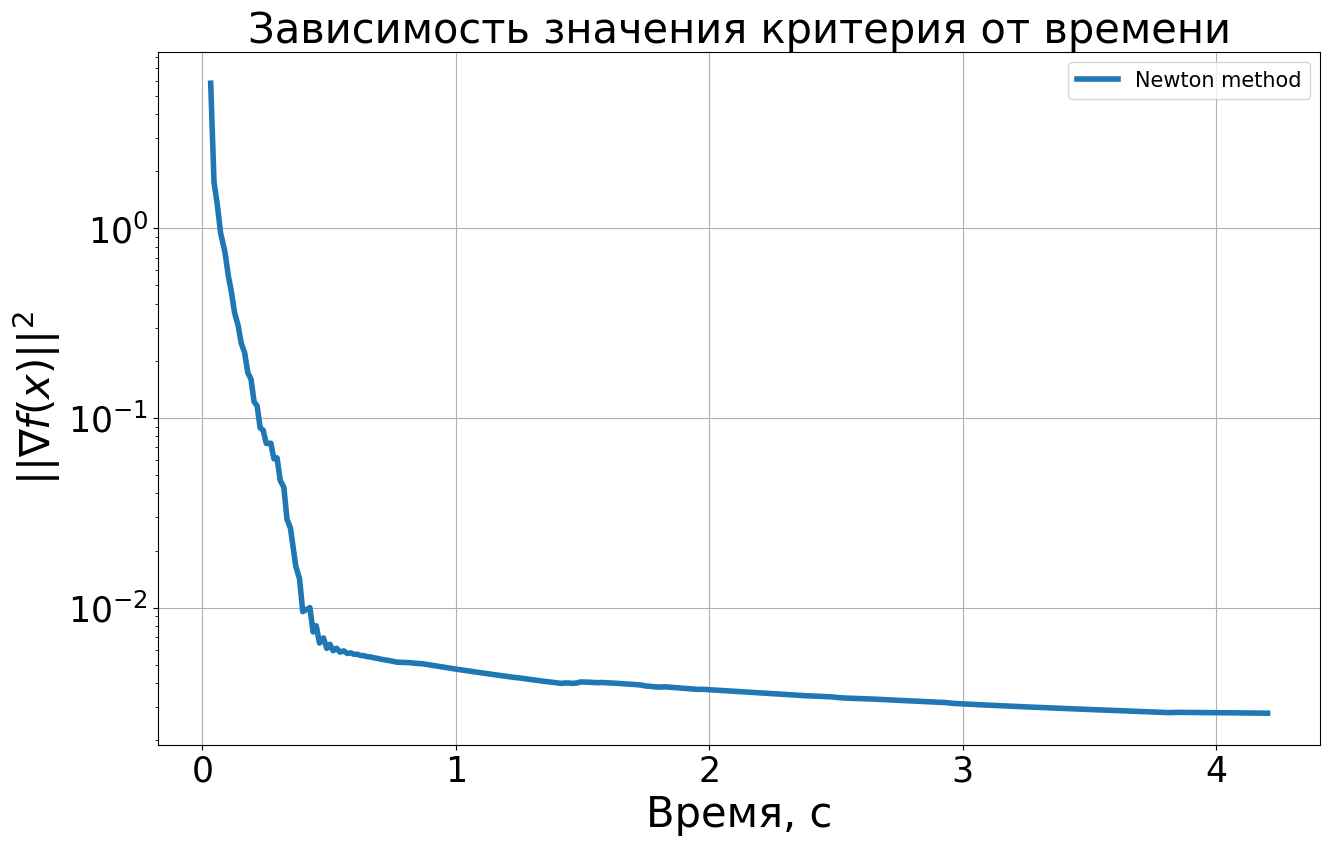

In [ ]:
plt.figure(figsize=(15, 9))

plt.semilogy(NW[1], NW[0], linewidth=4, label = 'Newton method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Время, с", fontsize=30)
plt.ylabel(r"$||\nabla f(x)||^2$", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()

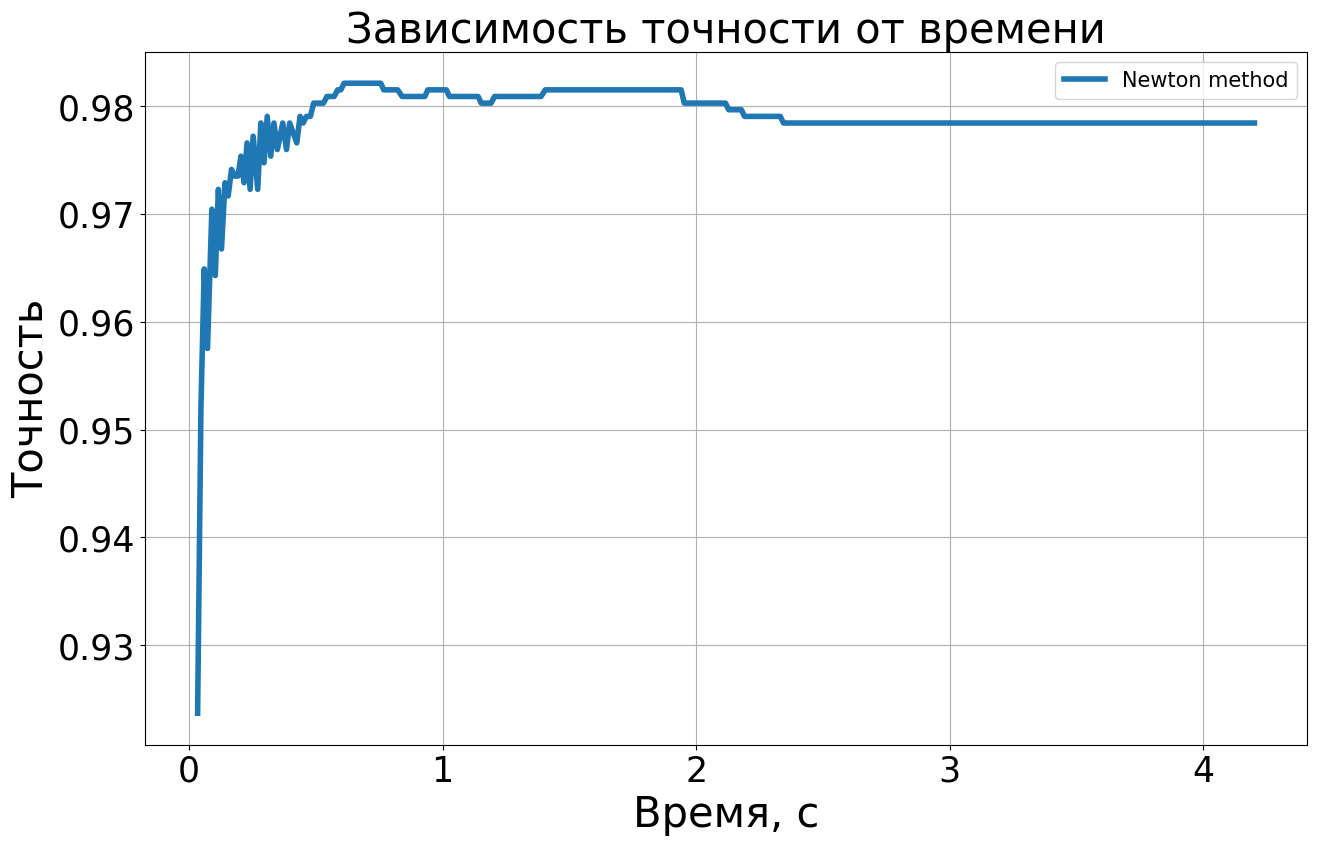

In [ ]:
plt.figure(figsize=(15, 9))

plt.plot(NW[1], NW[2], linewidth=4, label = 'Newton method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Время, с", fontsize=30)
plt.ylabel(r"Точность", fontsize=30)
plt.title(r"Зависимость точности от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()